#### The aim of this notebook is to generate nice videos where the following things are aligned
 - a registered 2p movie of the conditioned neuron
 - video of the face of the mouse
 - calcium trace of the conditioned neurons
 - lickport position
 - go cue


In [35]:
import BCI_analysis
import os, json
import numpy as np
import matplotlib.pyplot as plt
import gc
def load_and_calculate_dff(directory,scalar_f0 = False,photostim = False,correct_offset = False,moving_average_window = np.nan):
    """
    """
    
    F = np.load(os.path.join(directory,'F.npy'))
    Fneu = np.load(os.path.join(directory,'Fneu.npy'))
    F0 = np.load(os.path.join(directory,'F0.npy'))
    
    if correct_offset:
        f0_correction_dict = np.load(os.path.join(directory,'channel_offset.npy'),allow_pickle=True).tolist()
        
        F+=f0_correction_dict['channel_offset']
        F0+=f0_correction_dict['channel_offset']
        Fneu+=f0_correction_dict['channel_offset']
        print('corrected offset: {}'.format(f0_correction_dict['channel_offset']))
    F0_scalar = np.nanmedian(F0,1)[:,np.newaxis]
    
    if photostim:
        ops =  np.load(os.path.join(directory,'ops.npy'),allow_pickle = True).tolist()
        F,Fneu = BCI_analysis.io_suite2p.remove_stim_artefacts(F,Fneu,ops['frames_per_file'])
    if scalar_f0:
        dFF = (F-F0_scalar)/F0_scalar
    else:
        dFF = (F-F0)/F0
    
    
    if np.isnan(moving_average_window):
        return dFF,F,F0,F0_scalar,Fneu
    else:
        try:
            photon_counts = np.load(os.path.join(directory,'photon_counts.npy'),allow_pickle= True).tolist()
        except:
            print('no photon counts file found, going a directory above')
            dir_now,_ = os.path.split(directory)
            photon_counts = np.load(os.path.join(dir_now,'photon_counts.npy'),allow_pickle= True).tolist()
        f0_photon_counts_per_roi = photon_counts['F0_photon_counts']*moving_average_window
        dFF_filt = []
        for f in dFF:
            dFF_filt.append(BCI_analysis.pipeline_utils.rollingfun(f,moving_average_window))
        dFF_filt = np.asarray(dFF_filt)
        signal_photon_count =(dFF_filt)*f0_photon_counts_per_roi[:,np.newaxis] 
        noise_photon_count = (dFF_filt+1)*f0_photon_counts_per_roi[:,np.newaxis]
        snr_trace = signal_photon_count/np.sqrt(noise_photon_count)
        return dFF,F,F0,F0_scalar,Fneu,snr_trace






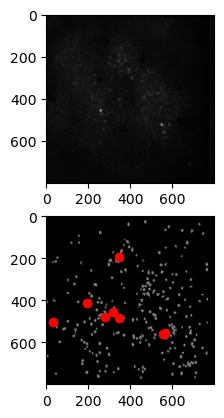

In [45]:
sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
local_temp_dir = '/home/jupyter/temp/' 
metadata_dir = '/home/jupyter/bucket/Metadata/' 
raw_scanimage_dir_base ='/home/jupyter/bucket/Data/Calcium_imaging/raw/' 
suite2p_dir_base = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/'
setup = 'Bergamo-2P-Photostim'

subject = 'BCI_29'#'BCI_34'
fov = 'FOV_02'#'FOV_04'#'FOV_03'
#sessions = ['071322','071422']
session = '042922'#'040722'#'071322'
# data_dict = {}
# session_file = '{}-{}-{}.npy'.format(subject,session,fov)
# data_dict[session] = BCI_analysis.io_python.read_sessionwise_npy(os.path.join(sessionwise_base_dir,subject,session_file))
session_bpod_file = os.path.join(bpod_path,setup,subject,'{}-bpod_zaber.npy'.format(session))
bpod_data=np.load(session_bpod_file,allow_pickle=True).tolist()
scalar_f0 = False
correct_offset = False
session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
fov_dir = os.path.join(suite2p_dir_base,setup,subject,fov)


F = np.load(os.path.join(session_dir,'F.npy'))

F0 = np.load(os.path.join(session_dir,'F0.npy'))

dFF = (F-F0)/F0


session_ops_file = os.path.join(session_dir,'ops.npy')
fov_stats_file = os.path.join(fov_dir,'stat.npy')
cond_s2p_idx,closed_loop_trial,scanimage_filenames = BCI_analysis.pipeline_imaging.find_conditioned_neuron_idx(session_bpod_file,
                                                                                                               session_ops_file,
                                                                                                               fov_stats_file,
                                                                                                               plot = True)
stat = np.load(fov_stats_file,allow_pickle=True).tolist()
scanimage_filenames = np.asarray(scanimage_filenames)[np.asarray(closed_loop_trial)]

with open(os.path.join(session_dir,'filelist.json'), 'r') as f:
    filelist_dict = json.load(f)
cn_idx = cond_s2p_idx[11]



In [46]:
trial_starts = []
for trial_i in np.arange(len(scanimage_filenames)):
    
    trial_si_name = scanimage_filenames[trial_i]

    spont_end_file_idx = np.where(np.asarray(filelist_dict['file_name_list'])==scanimage_filenames[0])[0][0]
    spont_frame_num = np.sum(np.asarray(filelist_dict['frame_num_list'])[:spont_end_file_idx])
    si_file_idx = np.where(np.asarray(filelist_dict['file_name_list'])==trial_si_name)[0][0]
    si_start_frame = np.sum(np.asarray(filelist_dict['frame_num_list'])[:si_file_idx])
    trial_starts.append(si_start_frame)
    
trial_starts = np.asarray(trial_starts)   


F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(dFF,
                                                                   trial_starts,
                                                                   50,
                                                                   100)

(2.0, 10.0)

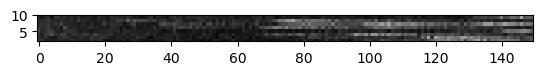

In [59]:
plt.imshow(F_photostim_aligned[:,cn_idx,:].T)
plt.ylim([2,10])

In [60]:
import cv2 
import os 
import suite2p
import scipy
BinaryFile = suite2p.io.BinaryFile
all_dff_traces = []
all_dff_times = []
all_frames = []
all_go_cue_times = []
all_lick_times = []
all_lickport_step_times = []
all_reward_times = []
start_time = 0
frame_idx_list = []
for trial_i in np.arange(0,10):
    
    trial_si_name = scanimage_filenames[trial_i]

    spont_end_file_idx = np.where(np.asarray(filelist_dict['file_name_list'])==scanimage_filenames[0])[0][0]
    spont_frame_num = np.sum(np.asarray(filelist_dict['frame_num_list'])[:spont_end_file_idx])

    si_file_idx = np.where(np.asarray(filelist_dict['file_name_list'])==trial_si_name)[0][0]
    si_start_frame = np.sum(np.asarray(filelist_dict['frame_num_list'])[:si_file_idx])
    si_end_frame = np.sum(np.asarray(filelist_dict['frame_num_list'])[:si_file_idx+1])
    frame_idx_list.append(np.arange(si_start_frame,si_end_frame))
    for bpod_trial_i, scname in enumerate(bpod_data['scanimage_file_names']):
        if trial_si_name == scname[0]:
            break
    frame_rate = float(bpod_data['scanimage_tiff_headers'][bpod_trial_i][0]['frame_rate'])
    dff_trace  =dFF[cn_idx,si_start_frame:si_end_frame]
    dff_time = np.arange(len(dff_trace))/frame_rate
    # dff_trace = np.kron(dff_trace,np.ones(2))
    # dff_time = np.kron(dff_time,np.ones(2))
    lickport_step_times = bpod_data['zaber_move_forward'][bpod_trial_i]
    lick_times = bpod_data['lick_L'][bpod_trial_i]
    reward_times = bpod_data['reward_L'][bpod_trial_i]
    go_cue_times= bpod_data['go_cue_times'][bpod_trial_i]
    threshold_crossing_times= bpod_data['threshold_crossing_times'][bpod_trial_i]
    

    video_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/raw/'+setup
    camera = 'side'
    for video_i in range(len(bpod_data['behavior_movie_name_list'][bpod_trial_i])):
        video_file = os.path.join(video_base_dir,bpod_data['behavior_movie_name_list'][bpod_trial_i][video_i].strip(' "').strip("'")[len('/home/labadmin/Data/Behavior_videos/'):])
        if camera in video_file:
            break
    video_metadata_file = video_file[:-4]+'.json'
    with open(video_metadata_file, 'r') as f:
        video_dict = json.load(f)

    video_indices = []
    for t in dff_time:
        video_indices.append(np.argmin(np.abs(video_dict['frame_times']-t)))

    video = cv2.VideoCapture(video_file) 

    currentframe = -1
    frame_list = []
    while(True): 
        ret,frame = video.read() 
        if ret: 
            currentframe += 1
            if currentframe in video_indices:
                for _ in range(sum(np.asarray(video_indices) == currentframe)):
                    frame_list.append(frame)
            
        else: 
            break
    cv2.destroyAllWindows()
    
    all_dff_traces.append(dff_trace)
    all_dff_times.append(dff_time+start_time)
    all_frames.append(frame_list)
    all_go_cue_times.append(go_cue_times+start_time)
    all_lick_times.append(lick_times+start_time)
    all_reward_times.append(reward_times+start_time)
    all_lickport_step_times.append(lickport_step_times+start_time)
    start_time += dff_time[-1]

ops =  np.load(os.path.join(session_dir,'ops.npy'),allow_pickle = True).tolist()
binaryfile = os.path.join(session_dir,'data.bin')
frames_needed = np.concatenate(frame_idx_list)
with BinaryFile(Ly=ops['Ly'], Lx=ops['Lx'], read_filename=binaryfile) as f:   
    frames  =f.ix(frames_needed)   
    
    

#ax_lickport.set_xlim([5,10])


all_dff_traces = np.concatenate(all_dff_traces)
all_dff_times = np.concatenate(all_dff_times)
all_frames = np.concatenate(all_frames)
all_go_cue_times = np.concatenate(all_go_cue_times)
all_lick_times = np.concatenate(all_lick_times)
all_lickport_step_times = np.concatenate(all_lickport_step_times)
all_reward_times= np.concatenate(all_reward_times)

#frames_filt = scipy.ndimage.gaussian_filter(frames, [5,0,0])
frames_filt = []
window = 20
for frame_i,frame in enumerate(frames):
    start_ = np.max([0,frame_i-window])
    end_ = start_+window
    frames_filt.append(np.asarray(np.mean(frames[start_:end_],0),dtype = np.int16))
frames_filt = np.asarray(frames_filt)
    

In [26]:
bpod_data['behavior_movie_name_list'][3]

["'/home/labadmin/Data/Behavior_videos/side/bci26/2022-04-08_10-25-55/trial_00055__2022-04-08_10-26-37.mp4'",
 " '/home/labadmin/Data/Behavior_videos/bottom/bci26/2022-04-08_10-25-53/trial_00056__2022-04-08_10-26-37.mp4'",
 " '/home/labadmin/Data/Behavior_videos/side/bci26/2022-04-08_10-25-55/trial_00073__2022-04-08_10-26-45.mp4'",
 " '/home/labadmin/Data/Behavior_videos/side/bci26/2022-04-08_10-25-55/trial_00075__2022-04-08_10-26-46.mp4'"]

In [62]:
import subprocess
import shutil
from matplotlib.gridspec import GridSpec

save_dir = '/home/jupyter/temp/video'

fig = plt.figure(figsize = [15,8])

p2_pixel_range = 200

gs1 = GridSpec(2, 2, height_ratios=[5, 1],width_ratios = [3,4])
ax_trace = fig.add_subplot(gs1[1, :])
ax_2p = fig.add_subplot(gs1[0, 0])
ax_faceimage = fig.add_subplot(gs1[0, 1])



# ax_trace = fig.add_subplot(2,2,1)
# ax_lickport = fig.add_subplot(2,2,3,sharex = ax_trace)
# ax_faceimage = fig.add_subplot(2,2,2)

plt.set_cmap('gray')
clims_2p = np.percentile(frames_filt.flatten(),[5,99.99])#clims_2p = [np.percentile(frames_filt.flatten(),5),np.max(frames_filt.flatten())]
clims_video = np.percentile(all_frames.flatten(),[5,99.99])
for frame in range(len(all_dff_traces)-1):
    #frame = len(all_dff_traces)-1
    ax_2p.cla()
    im = ax_2p.imshow(frames_filt[frame])
    im.set_clim(clims_2p)
    ax_2p.plot(stat[cn_idx]['med'][1],stat[cn_idx]['med'][0], 'o',markersize = 25, markerfacecolor='none', markeredgecolor='r')
    ax_2p.set_xlim([np.max([0,stat[cn_idx]['med'][1]-p2_pixel_range]),np.min([frames_filt.shape[1],stat[cn_idx]['med'][1]+p2_pixel_range])])
    ax_2p.set_ylim([np.max([0,stat[cn_idx]['med'][0]-p2_pixel_range]),np.min([frames_filt.shape[0],stat[cn_idx]['med'][0]+p2_pixel_range])])
    ax_2p.axis('off')
    ax_faceimage.cla()
    im_face = ax_faceimage.imshow(all_frames[frame][:400,100:-200,0])
    im_face.set_clim(clims_video)
    ax_faceimage.axis('off')
    
    ax_trace.cla()
    ax_trace.plot(all_dff_times[:frame],all_dff_traces[:frame],'k-')

    
    # ax_lickport.cla()
    # reward_needed = all_reward_times<=all_dff_times[frame]
    # ax_lickport.plot(all_reward_times[reward_needed],np.ones(sum(reward_needed))*2,'yo')
    # lick_needed = all_lick_times<=all_dff_times[frame]
    # ax_lickport.plot(all_lick_times[lick_needed],np.ones(sum(lick_needed))*2,'b|')
    # lickport_steps_needed = all_lickport_step_times<=all_dff_times[frame]
    # ax_trace.plot(all_lickport_step_times[lickport_steps_needed],np.ones(sum(lickport_steps_needed))*0,'r|')
    go_cue_times_needed = all_go_cue_times<=all_dff_times[frame]
    ax_trace.plot(all_go_cue_times[go_cue_times_needed],np.ones(sum(go_cue_times_needed))*np.percentile(all_dff_traces,[95]),'go')
    
    ax_trace.set_xlim([all_dff_times[0],all_dff_times[-1]])
    ax_trace.set_ylim(np.percentile(all_dff_traces,[0,100]))
    ax_trace.spines['top'].set_visible(False)
    ax_trace.spines['right'].set_visible(False)
    ax_trace.set_ylabel('dF/F')
    ax_trace.set_xlabel('Time (s)')
    #asdasdassa
    plt.savefig(save_dir + "/file%02d.png" % frame)
plt.close()
gc.collect()
os.chdir(save_dir)
subprocess.call([
    'ffmpeg', '-framerate', '20', '-i', 'file%02d.png', '-r', '20', '-pix_fmt', 'yuv420p',
    'sample_bci_video.mp4'
])
for file_name in os.listdir(save_dir):
    if '.png' in file_name:
        os.remove(file_name)
shutil.move(os.path.join(save_dir,'sample_bci_video.mp4'),'/home/jupyter/bucket/sample_bci_video.mp4')

ffmpeg version 4.1.9-0+deb10u1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --prefix=/usr --extra-version=0+deb10u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --en

'/home/jupyter/bucket/sample_bci_video.mp4'

In [1]:
import os, subprocess, shutil
save_dir = '/home/jupyter/temp/video'
os.chdir(save_dir)

subprocess.call([
    'ffmpeg', '-framerate', '20', '-i', 'file%02d.png', '-r', '20', '-pix_fmt', 'yuv420p',
    'sample_bci_video.mp4'
])
for file_name in os.listdir(save_dir):
    if '.png' in file_name:
        os.remove(file_name)
shutil.move(os.path.join(save_dir,'sample_bci_video.mp4'),'/home/jupyter/bucket/sample_bci_video.mp4')

ffmpeg version 4.1.9-0+deb10u1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --prefix=/usr --extra-version=0+deb10u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --en

'/home/jupyter/bucket/sample_bci_video.mp4'